<a href="https://colab.research.google.com/github/Abhi310/Air_Quality_analysis_and_prediction/blob/master/Air_quality_linear_randforest_svm_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [0]:
#Constants to classify the resluts of prediction in diferent group.
DIFF_FOR_PERFECT = 0.05
DIFF_FOR_EXCELLENT = 0.15
DIFF_FOR_GOOD =  0.30
DIFF_FOR_OK = 0.5

In [0]:
#Preinting the classified results.
def print_results(test_data,pred_data):
    perfect, excellent, good, ok, bad=0, 0, 0, 0, 0
    for i in range(test_data.size):
        if pred_data[i]>(test_data[i]-DIFF_FOR_PERFECT) and pred_data[i]<(test_data[i]+DIFF_FOR_PERFECT):
            perfect += 1
            continue
        
        if pred_data[i]>(test_data[i]-DIFF_FOR_EXCELLENT) and pred_data[i]<(test_data[i]+DIFF_FOR_EXCELLENT):
            excellent += 1
            continue
        
        if pred_data[i]>(test_data[i]-DIFF_FOR_GOOD) and pred_data[i]<(test_data[i]+DIFF_FOR_GOOD):
            good += 1
            continue
        
        if pred_data[i]>(test_data[i]-DIFF_FOR_OK) and pred_data[i]<(test_data[i]+DIFF_FOR_OK):
            ok += 1
            continue
        
        if pred_data[i]>(test_data[i]-0.01) and pred_data[i]<(test_data[i]+0.01):
            perfect += 1
            continue
        else:
            bad+=1
    
    print("Perfect Predictions:   " + str(perfect)+ "\nExcellent Predictions: " + str(excellent) + "\nGood Predictions:      " + str(good) + "\nQuite OK Predictions:  " + str(ok) + "\nBad Predictions:       " + str(bad))
    per = (perfect+excellent+good+ok)*100/test_data.size
    print('\nPercent of Considerable Predictions: ' + str(round(per,2)) + '%')




```
```

**Data Manipulating**

---



The Dataset is taken from UCI website. the link to dataset is: http://archive.ics.uci.edu/ml/datasets/air+quality

In [249]:
from google.colab import files
uploaded = files.upload()

In [250]:
df = pd.read_excel('AirQualityUCI.xlsx')
print('Shape of Data Frame: ',df.shape)
df.head(3)

Shape of Data Frame:  (9357, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.9,53.975000,0.750239


It is mentioned, the value of -200 means the value is missing.

In [251]:
for col in df.columns:
    print('Missing values in ' + col + ':\t' + str(len(df[df[col]==-200])))

Missing values in Date:	0
Missing values in Time:	0
Missing values in CO(GT):	1683
Missing values in PT08.S1(CO):	366
Missing values in NMHC(GT):	8443
Missing values in C6H6(GT):	366
Missing values in PT08.S2(NMHC):	366
Missing values in NOx(GT):	1639
Missing values in PT08.S3(NOx):	366
Missing values in NO2(GT):	1642
Missing values in PT08.S4(NO2):	366
Missing values in PT08.S5(O3):	366
Missing values in T:	366
Missing values in RH:	366
Missing values in AH:	366


Column NMHC(GT) has 8443 missing values out of 9357, so we will drop this column.
Column CO(GT), NOx(GT) and  NO2(GT) has 1683 values out of 9357 values are missing. 

In [0]:
df=df[(df['PT08.S2(NMHC)']!=-200)&(df['NOx(GT)']!=-200)&(df['CO(GT)']!=-200)]
df=df.drop(columns={'NMHC(GT)'})

In [253]:
df = df.replace(-200.00,np.NaN)

df = df.fillna(df.mean())

for col in df.columns:
    print('Missing values in ' + col + ':\t' + str(len(df[df[col]==-200])))

Missing values in Date:	0
Missing values in Time:	0
Missing values in CO(GT):	0
Missing values in PT08.S1(CO):	0
Missing values in C6H6(GT):	0
Missing values in PT08.S2(NMHC):	0
Missing values in NOx(GT):	0
Missing values in PT08.S3(NOx):	0
Missing values in NO2(GT):	0
Missing values in PT08.S4(NO2):	0
Missing values in PT08.S5(O3):	0
Missing values in T:	0
Missing values in RH:	0
Missing values in AH:	0


Now we have no more missing values.

In [254]:
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000
mean,2.182488,1119.772813,10.555515,958.477151,250.609965,816.731651,113.858608,1452.659922,1057.632200,17.758092,48.873123,0.985678
std,1.440863,218.697536,7.463805,264.010540,208.571553,251.853737,47.454450,353.283017,406.418998,8.846898,17.433063,0.401046
min,0.100000,647.250000,0.181525,390.250000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.100000,956.625000,4.927071,759.750000,103.000000,642.250000,79.000000,1206.875000,759.500000,11.200000,35.318750,0.694156
50%,1.900000,1084.750000,8.791441,931.125000,186.000000,785.375000,110.000000,1457.625000,1006.250000,16.850000,49.175000,0.954064
75%,2.900000,1253.812500,14.579057,1135.250000,334.375000,946.500000,142.000000,1683.062500,1322.000000,23.725000,62.224999,1.251619
max,11.900000,2039.750000,63.741476,2214.000000,1479.000000,2682.750000,332.600000,2775.000000,2522.750000,44.600000,88.725000,2.180639


In [0]:
p = []
for i in df['PT08.S1(CO)']:
    p.append(i/650)

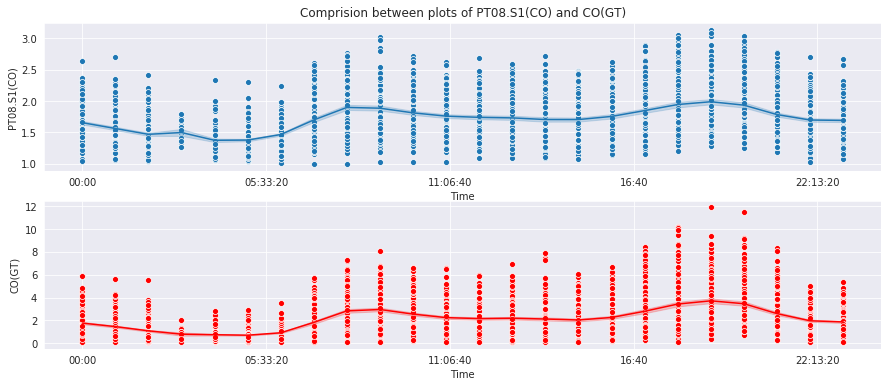

In [256]:
plt.figure(figsize=(15,6))

plt.subplot(2,1,1)
plt.title('Comprision between plots of PT08.S1(CO) and CO(GT)')
sns.scatterplot(y=p, x=df['Time'])
sns.lineplot(y=p, x=df['Time'])
plt.ylabel('PT08.S1(CO)')

plt.subplot(2,1,2)
sns.scatterplot(y=df['CO(GT)'], x=df['Time'], color='red')
sns.lineplot(y=df['CO(GT)'], x=df['Time'], color='red');


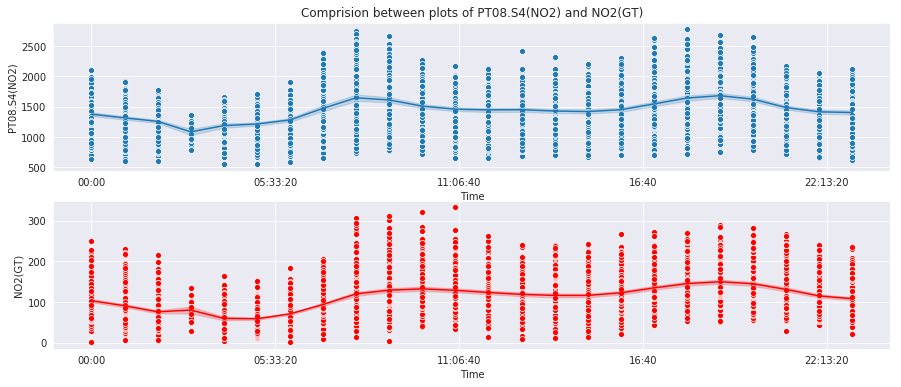

In [257]:
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.title('Comprision between plots of PT08.S4(NO2) and NO2(GT)')
sns.scatterplot(y=df['PT08.S4(NO2)'], x=df['Time'])
sns.lineplot(y=df['PT08.S4(NO2)'], x=df['Time'])

plt.subplot(2,1,2)
sns.scatterplot(y=df['NO2(GT)'], x=df['Time'], color='red')
sns.lineplot(y=df['NO2(GT)'], x=df['Time'], color='red');

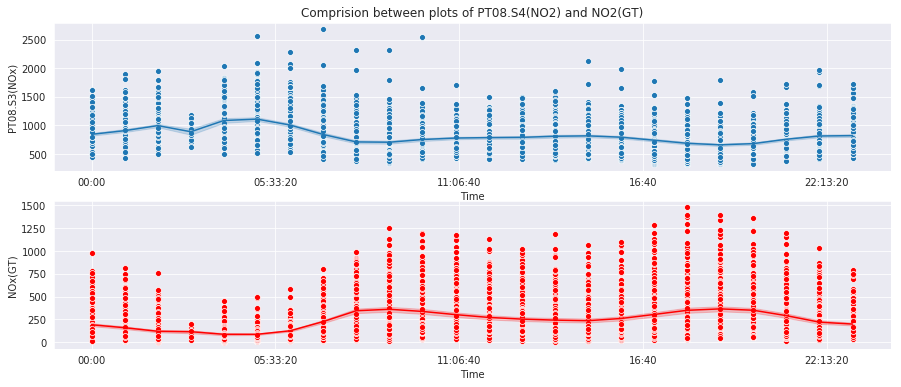

In [258]:
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.title('Comprision between plots of PT08.S4(NO2) and NO2(GT)')
sns.scatterplot(y=df['PT08.S3(NOx)'], x=df['Time'])
sns.lineplot(y=df['PT08.S3(NOx)'], x=df['Time'])

plt.subplot(2,1,2)
sns.scatterplot(y=df['NOx(GT)'], x=df['Time'], color='red')
sns.lineplot(y=df['NOx(GT)'], x=df['Time'], color='red');

In [0]:
import datetime
#df[df['Time']==datetime.time(4, 0)]

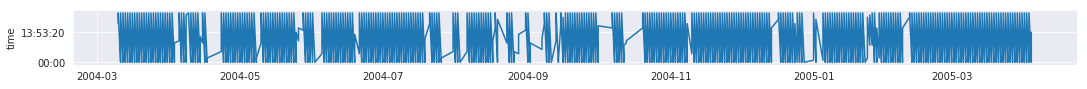

In [260]:
plt.figure(figsize=(18,1))
plt.plot(df['Date'],df['Time']);

The data is not uniform there are many missing days or series of missing days in the data

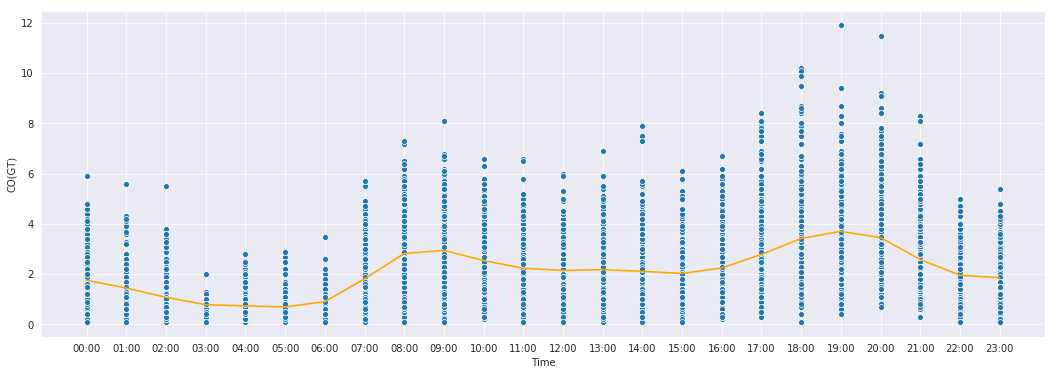

In [261]:
#df[df['CO(GT)']>7]
time=[]
for i in range(24):
    hr = str(i) + ':00'
    time.append(hr)
    
plt.figure(figsize=(18,6))
sns.scatterplot(df['Time'], df['CO(GT)'])
sns.lineplot(df['Time'], df['CO(GT)'], ci=0, color='orange')
plt.xticks(time);

We can clearly see the amount of CO in air is at most during 18:00 to 20:00 and least around 03:00 to 6:00.

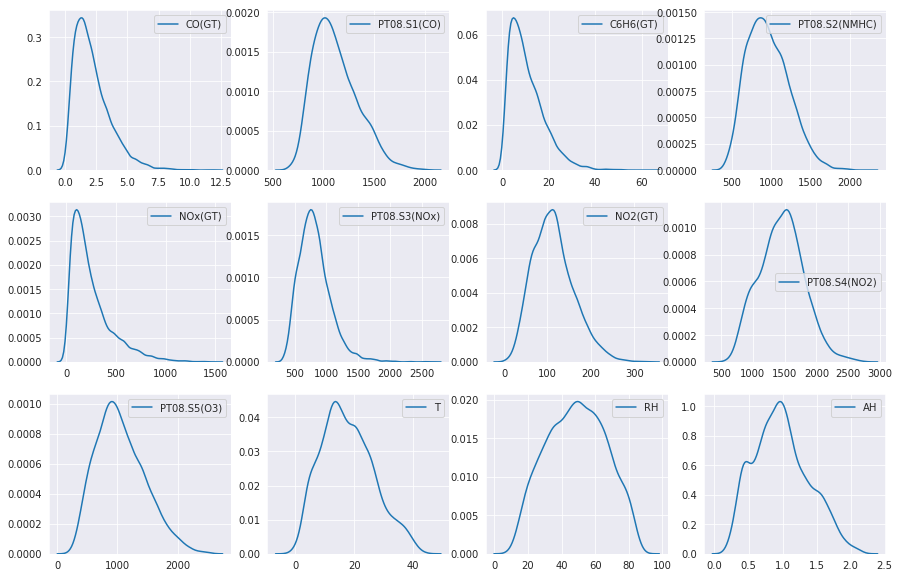

In [262]:
plt.figure(figsize=(15,10))
i=1
column_list = df.columns.values[2:]
for col in column_list:
    plt.subplot(3,4,i)
    sns.kdeplot(df[col])
    i+=1;


In [0]:
df = df.drop(columns={'PT08.S1(CO)','PT08.S4(NO2)'})

In [0]:
y = df.iloc[:,2].values
X = df.iloc[:,3:].values
X = np.c_[np.ones(df.shape[0]),df.iloc[:,3:].values];

In [265]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)


print('X train size: ', X_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', X_test.shape)
print('y test size: ', y_test.shape)

X train size:  (6249, 10)
y train size:  (6249,)
X test size:  (695, 10)
y test size:  (695,)


In [0]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train.ravel());


In [0]:
y_pred_linear = regressor.intercept_ + X_test.dot(regressor.coef_)
for i in range(len(y_pred_linear)):
    y_pred_linear[i]=round(y_pred_linear[i],2)

In [268]:
print_results(y_test,y_pred_linear)

Perfect Predictions:   98
Excellent Predictions: 184
Good Predictions:      194
Quite OK Predictions:  120
Bad Predictions:       99

Percent of Considerable Predictions: 85.76%


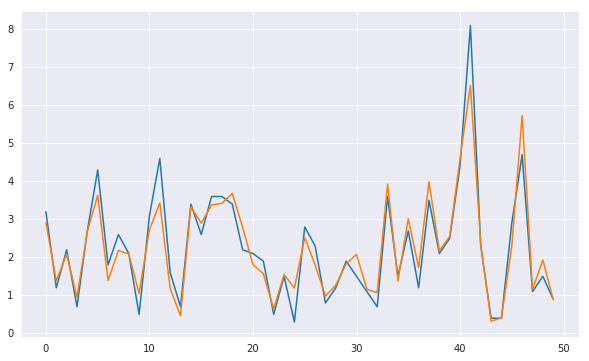

In [269]:
plt.figure(figsize=(10,6))
plt.plot(y_test[0:50])
plt.plot(y_pred_linear[0:50])

In [270]:
error_linear = y_test - y_pred_linear
error_ab_linear = y_test - y_pred_linear
for i  in range(len(error_linear)):
    if error_linear[i]<0: error_ab_linear[i]=error_ab_linear[i]*(-1)
error_sq_linear = error_linear**2
print('LINEAR MODEL:')
print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab_linear.mean()))
print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq_linear.mean()))

LINEAR MODEL:
	Mean Absolute Error on Test Set: 0.29
	Mean Square Error on Test Set: 0.20


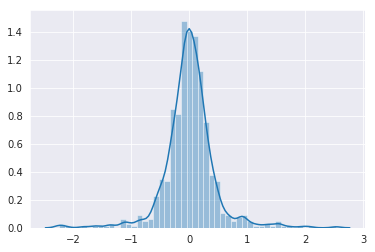

In [271]:
sns.distplot(error_linear)

**RANDOM FOREST**



In [272]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10,random_state=0)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
y_pred_randforest = model.predict(X_test)

In [274]:
print_results(y_test,y_pred_randforest)

Perfect Predictions:   116
Excellent Predictions: 204
Good Predictions:      149
Quite OK Predictions:  121
Bad Predictions:       105

Percent of Considerable Predictions: 84.89%


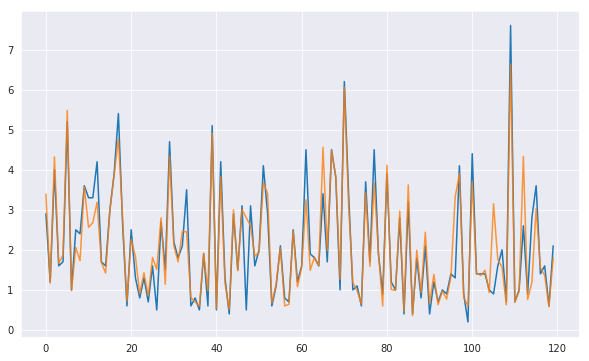

In [275]:
plt.figure(figsize=(10,6))
plt.plot(y_test[400:520])
plt.plot(y_pred_randforest[400:520],alpha=0.8)

In [276]:
error_randforest = y_test - y_pred_randforest
error_ab_randforest = y_test - y_pred_randforest
for i  in range(len(error_randforest)):
    if error_ab_randforest[i]<0: error_ab_randforest[i]=error_ab_randforest[i]*(-1)
error_sq_randforest = error_randforest**2
print('Random Forest MODEL:')
print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab_randforest.mean()))
print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq_randforest.mean()))

Random Forest MODEL:
	Mean Absolute Error on Test Set: 0.28
	Mean Square Error on Test Set: 0.19


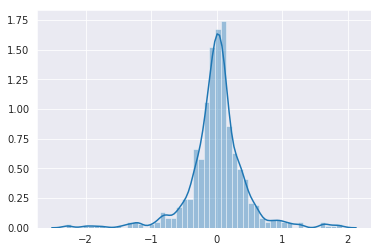

In [277]:
sns.distplot(error_randforest)

**SVM**

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.fit_transform(X_test)

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


model = SVR(kernel='rbf', gamma='scale')
model.fit(norm_X_train, y_train)

y_pred_svm = model.predict(norm_X_test);

In [280]:
print_results(y_test, y_pred_svm)

Perfect Predictions:   129
Excellent Predictions: 239
Good Predictions:      165
Quite OK Predictions:  81
Bad Predictions:       81

Percent of Considerable Predictions: 88.35%


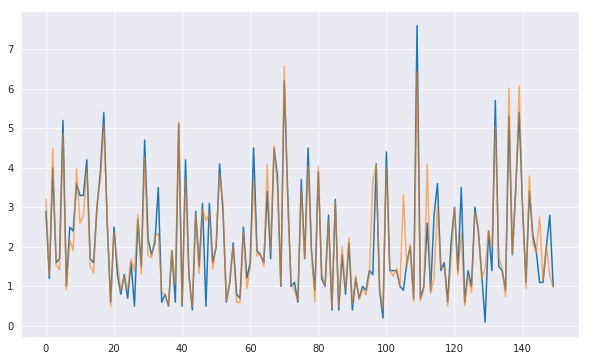

In [281]:
plt.figure(figsize=(10,6))
plt.plot(y_test[400:550])
plt.plot(y_pred_svm[400:550],alpha=0.6)

In [282]:
error_svm = y_test - y_pred_svm
error_ab_svm = y_test - y_pred_svm
for i  in range(len(error_svm)):
    if error_ab_svm[i]<0: 
        error_ab_svm[i]=error_ab_svm[i]*(-1)
error_sq_svm = error_svm**2
print('SVM MODEL:')
print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab_svm.mean()))
print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq_svm.mean()))

SVM MODEL:
	Mean Absolute Error on Test Set: 0.25
	Mean Square Error on Test Set: 0.17


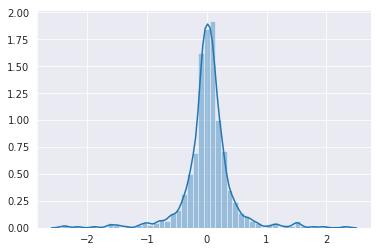

In [283]:
sns.distplot(error_svm);



---



**DEEP NEURAL NETWORK**

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
df.drop(columns={'Date','Time'}, inplace=True)

In [286]:
train_dataset = df.sample(frac=0.9,random_state=0)
test_dataset = df.drop(train_dataset.index)
print('Traindata shape: ' + str(train_dataset.shape))
print('Testdata shape: ' +  str(test_dataset.shape))

Traindata shape: (6250, 10)
Testdata shape: (694, 10)


In [287]:
train_stats = train_dataset.describe()
train_stats.pop("CO(GT)")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
C6H6(GT),6250.0,10.532473,7.477476,0.181525,4.892568,8.775651,14.559465,63.741476
PT08.S2(NMHC),6250.0,957.465413,264.395634,390.250000,758.000000,930.500000,1134.625000,2214.000000
NOx(GT),6250.0,250.028896,208.187334,2.000000,103.000000,185.000000,333.000000,1479.000000
PT08.S3(NOx),6250.0,818.282840,254.055363,322.000000,641.812500,785.250000,948.750000,2682.750000
NO2(GT),6250.0,113.594524,47.357980,2.000000,79.000000,109.900000,142.000000,332.600000
PT08.S5(O3),6250.0,1056.857173,407.194737,221.000000,758.875000,1005.500000,1319.437500,2522.750000
T,6250.0,17.799575,8.835873,-1.275000,11.275000,16.912500,23.718750,44.600000
RH,6250.0,48.809240,17.413901,9.175000,35.306251,49.137500,62.168750,88.725000
AH,6250.0,0.986386,0.400077,0.184679,0.695873,0.956087,1.254641,2.180639


In [0]:
train_labels = train_dataset.pop('CO(GT)')
test_labels = test_dataset.pop('CO(GT)')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
norm_X_train = norm(train_dataset)
norm_X_test = norm(test_dataset)

In [0]:
y_train = train_labels
y_test = test_labels

In [0]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[norm_X_train.shape[1]]),
        #keras.layers.Dropout(0.2),
        #keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation=tf.nn.relu),
        #keras.layers.Dropout(0.1),
        #keras.layers.BatchNormalization(),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    
    model.compile(loss='mean_squared_error',
                  optimizer = tf.keras.optimizers.Adam(lr=0.05, decay=1e-6),
                  metrics = ['mean_absolute_error', 'mean_squared_error','accuracy']
                 )
    return model

model = build_model();

In [292]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_88 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_89 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 17        
Total params: 5,857
Trainable params: 5,857
Non-trainable params: 0
_________________________________________________________________


In [293]:
example_batch = norm_X_train[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.2840778 ],
       [-0.03208649],
       [-0.07248773],
       [-0.12097129],
       [-0.15888837],
       [-0.06591495],
       [-0.19138333],
       [-0.04933978],
       [-0.17788851],
       [-0.10944787]], dtype=float32)

In [294]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

Epochs = 1500

first_model = model.fit(norm_X_train, y_train,
                        epochs=Epochs,
                        validation_split=0.2,
                        verbose=0,
                        callbacks=[PrintDot()]
                       )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

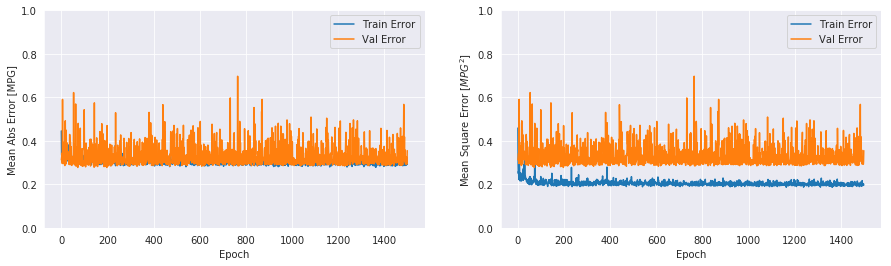

In [309]:
def plot_model(model):
    hist = pd.DataFrame(first_model.history)
    hist['epoch'] = first_model.epoch
    plt.figure(figsize=(3,4))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
    plt.ylim([0,1])
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.subplots_adjust(right=4)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
    plt.ylim([0,1])
    plt.legend()

plot_model(first_model)

In [310]:
 hist = pd.DataFrame(first_model.history)
hist['epoch'] = first_model.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,acc,val_loss,val_mean_absolute_error,val_mean_squared_error,val_acc,epoch
1495,0.194923,0.288027,0.194923,0.0372,0.245999,0.306393,0.245999,0.0424,1495
1496,0.197727,0.293867,0.197727,0.0366,0.254817,0.325230,0.254817,0.0416,1496
1497,0.202973,0.302957,0.202973,0.0370,0.234558,0.292557,0.234558,0.0432,1497
1498,0.200594,0.300406,0.200594,0.0374,0.251941,0.304906,0.251941,0.0432,1498
1499,0.196635,0.292225,0.196635,0.0374,0.279440,0.354982,0.279440,0.0400,1499



..................

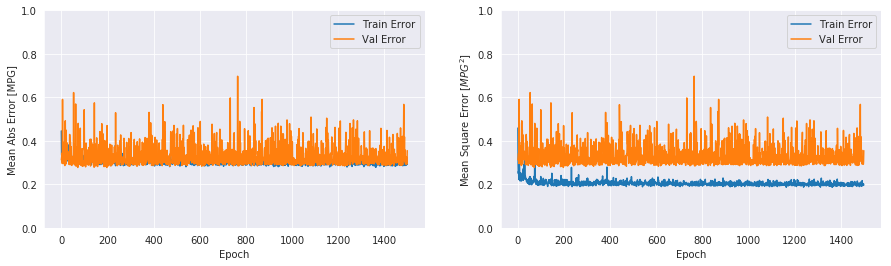

In [311]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

second_model = model.fit(norm_X_train, y_train, epochs=Epochs,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_model(second_model)

In [312]:
loss, mae, mse, a = model.evaluate(norm_X_train, y_train, verbose=0)

print('Loss : {:0.2f} \nMean Absolute Error: {:0.2f} \nMean Squared Error: {:0.2f}'.format(loss,mae,mse))

Loss : 0.23 
Mean Absolute Error: 0.32 
Mean Squared Error: 0.23


In [0]:
y_pred_nn = model.predict(norm_X_test)

In [0]:
y_test = np.array(y_test)

In [315]:
y_test = np.reshape(y_test, (-1,1))
y_test.shape

(694, 1)

In [316]:
print_results(y_test, y_pred_nn)

Perfect Predictions:   84
Excellent Predictions: 148
Good Predictions:      185
Quite OK Predictions:  163
Bad Predictions:       114

Percent of Considerable Predictions: 83.57%


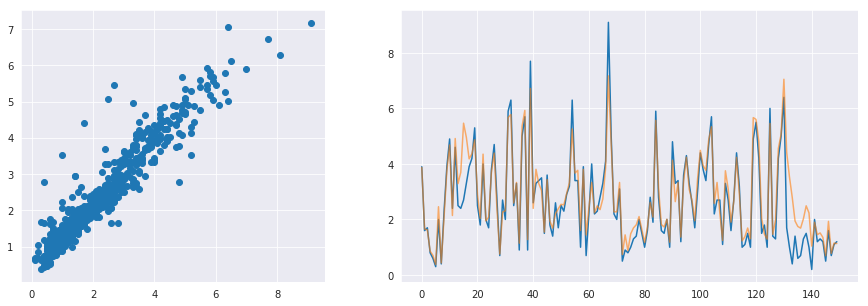

In [317]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
ax0.scatter(y_test, y_pred_nn)

ax1 = plt.subplot(gs[1])
ax1.plot(y_test[400:550])
ax1.plot(y_pred_nn[400:550],alpha=0.6);


 

In [318]:
error_nn = y_test - y_pred_nn
error_ab_nn = y_test - y_pred_nn
for i  in range(len(error_nn)):
    if error_ab_nn[i]<0: 
        error_ab_nn[i]=error_ab_nn[i]*(-1)
error_sq_nn = error_nn**2
print('NN MODEL:')
print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab_nn.mean()))
print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq_nn.mean()))

NN MODEL:
	Mean Absolute Error on Test Set: 0.32
	Mean Square Error on Test Set: 0.22


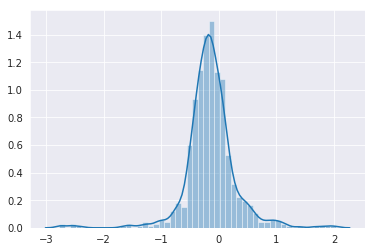

In [319]:
sns.distplot(error_nn)

In [320]:
print('LINEAR MODEL:')
print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab_linear.mean()))
print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq_linear.mean()))

print('\nRANDOM FOREST MODEL:')
print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab_randforest.mean()))
print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq_randforest.mean()))

print('\nSVM MODEL:')
print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab_svm.mean()))
print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq_svm.mean()))

print('\nNN MODEL:')
print('\tMean Absolute Error on Test Set: {:0.2f}'.format(error_ab_nn.mean()))
print('\tMean Square Error on Test Set: {:0.2f}'.format(error_sq_nn.mean()))

LINEAR MODEL:
	Mean Absolute Error on Test Set: 0.29
	Mean Square Error on Test Set: 0.20

RANDOM FOREST MODEL:
	Mean Absolute Error on Test Set: 0.28
	Mean Square Error on Test Set: 0.19

SVM MODEL:
	Mean Absolute Error on Test Set: 0.25
	Mean Square Error on Test Set: 0.17

NN MODEL:
	Mean Absolute Error on Test Set: 0.32
	Mean Square Error on Test Set: 0.22


In [0]:
def circle_outliers(xlim, e_linear, e_randf, e_svm, e_nn):
    x=np.arange(0,len(e_linear))
    s_l=[]
    s_r=[]
    s_s=[]
    s_n=[]
    min_s=0
    max_s=500
    threshold=1.4
    alpha=0.4
    for i in range(len(e_linear)):
        s_l.append(min_s)
        s_r.append(min_s)
        s_s.append(min_s)
        s_n.append(min_s)
        if e_linear[i]<-1*threshold or e_linear[i]>threshold: 
            s_l[i]=max_s
        if e_randf[i]<-1*threshold or e_randf[i]>threshold:
            s_r[i]=max_s
        if e_svm[i]<-1*threshold or e_svm[i]>threshold: 
            s_s[i]=max_s
        if e_nn[i]<-1*threshold or e_nn[i]>threshold: 
            s_n[i]=max_s
    
    plt.figure(figsize=(18,6))
    sns.scatterplot(x, e_svm, alpha=alpha, s=s_s, ci=0, color='black')
    sns.scatterplot(x, e_nn, alpha=alpha, s=s_n, ci=0, color='blue')
    sns.scatterplot(x, e_linear, alpha=alpha, s=s_l, ci=0, color='yellow')
    sns.scatterplot(x, e_randf, alpha=alpha, s=s_r, ci=0, color='red')
    
    sns.lineplot(x, e_svm, alpha=alpha, label='SVM', ci=0, color='black')
    sns.lineplot(x, e_nn, alpha=alpha, label='NN', ci=0, color='blue')
    sns.lineplot(x, e_linear, alpha=alpha, label='Linear', ci=0, color='yellow')
    sns.lineplot(x, e_randf, alpha=alpha, label='Rand. Forest', ci=0, color='red')
    plt.xlim([0,xlim])
    plt.axhline(-1*threshold, ls='--', alpha=0.3)
    plt.axhline(threshold, ls='--', alpha=0.3)
    plt.axhline(0, ls='--', alpha=0.3)
    plt.legend()
    plt.show()

In [0]:
error_linear = error_linear[0:694]
error_randforest = error_randforest[0:694]
error_svm = error_svm[0:694]

In [353]:
error_nn[67][0]

-0.14038021564483638

Exception: ignored

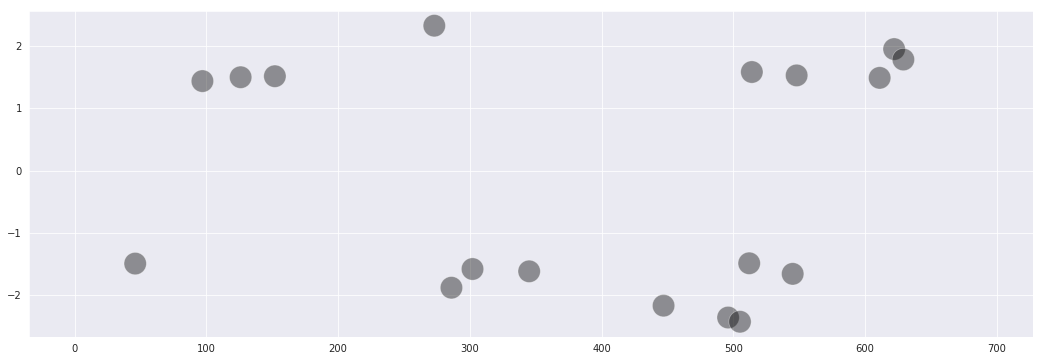

In [357]:
circle_outliers(400,error_linear,error_randforest,error_svm,error_nn)

In [0]:
[print('{} \t {:0.3f}'.format(i,error_nn[i])) for i in range(len(error_linear)) if error_nn[i]<-1.5]
print('')
[print('{} \t {:0.3f}'.format(i,error_svm[i])) for i in range(len(error_linear)) if error_svm[i]<-1.5]
print('')
[print('{} \t {:0.3f}'.format(i,error_randforest[i])) for i in range(len(error_linear)) if error_randforest[i]<-1.5]
print('')
[print('{} \t {:0.3f}'.format(i,error_linear[i])) for i in range(len(error_linear)) if error_linear[i]<-1.5]

In [0]:
error_linear[114]

In [0]:
y_pred_nn[331]

In [0]:
X_test[162]

In [0]:
plt.figure(figsize=(15,5))
plt.plot(y_test[:100])

In [0]:
y_test.max()

In [0]:
df[df['CO(GT)']==0.5]

In [0]:
corr_error_svm = y_test - y_pred_svm
temp_mean = corr_error_svm.mean()
corr_error_svm[162]=temp_mean
corr_error_svm[235]=temp_mean
corr_error_svm[331]=temp_mean
corr_error_sq_svm = corr_error_svm**2
print('\tMean Square Error on Test Set: {:0.2f}'.format(corr_error_sq_svm.mean()))

In [0]:
s = np.random.rand(100)
s.shape